Количество строк после соединения: 999584
Должно быть 999584 строк: True
Количество строк после фильтрации: 898068

=== АНАЛИЗ КАТЕГОРИЙ ПО ПОЛУ ===

ТОП-10 категорий с наибольшими расходами у ЖЕНЩИН:
           Female          Male                                   mcc_description
123  3.128363e+09  5.519128e+09  Финансовые институты — снятие наличности вручную
125  1.212393e+07  5.348158e+07          Финансовые институты — торговля и услуги
130  5.308196e+06  2.289341e+07            Денежные переводы MasterCard MoneySend
2    0.000000e+00 -1.215427e+05                       Подрядчики по электричеству
67   0.000000e+00 -8.645437e+05                                Продажа мотоциклов
110  0.000000e+00 -1.931533e+04         Прямой маркетинг — входящий телемаркетинг
141  0.000000e+00 -8.431953e+04                      Услуги копировальных центров
146  0.000000e+00 -3.807563e+06                                Прокат автомобилей
153  0.000000e+00 -6.715290e+03           Производство и дист

C:\Users\cren5\AppData\Local\Temp\ipykernel_41648\2542142883.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"{cat}: Мужчины = {male_spend:,.0f}, Женщины = {female_spend:,.0f}, М/Ж = {male_spend/female_spend:.2f}")
C:\Users\cren5\AppData\Local\Temp\ipykernel_41648\2542142883.py:178: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


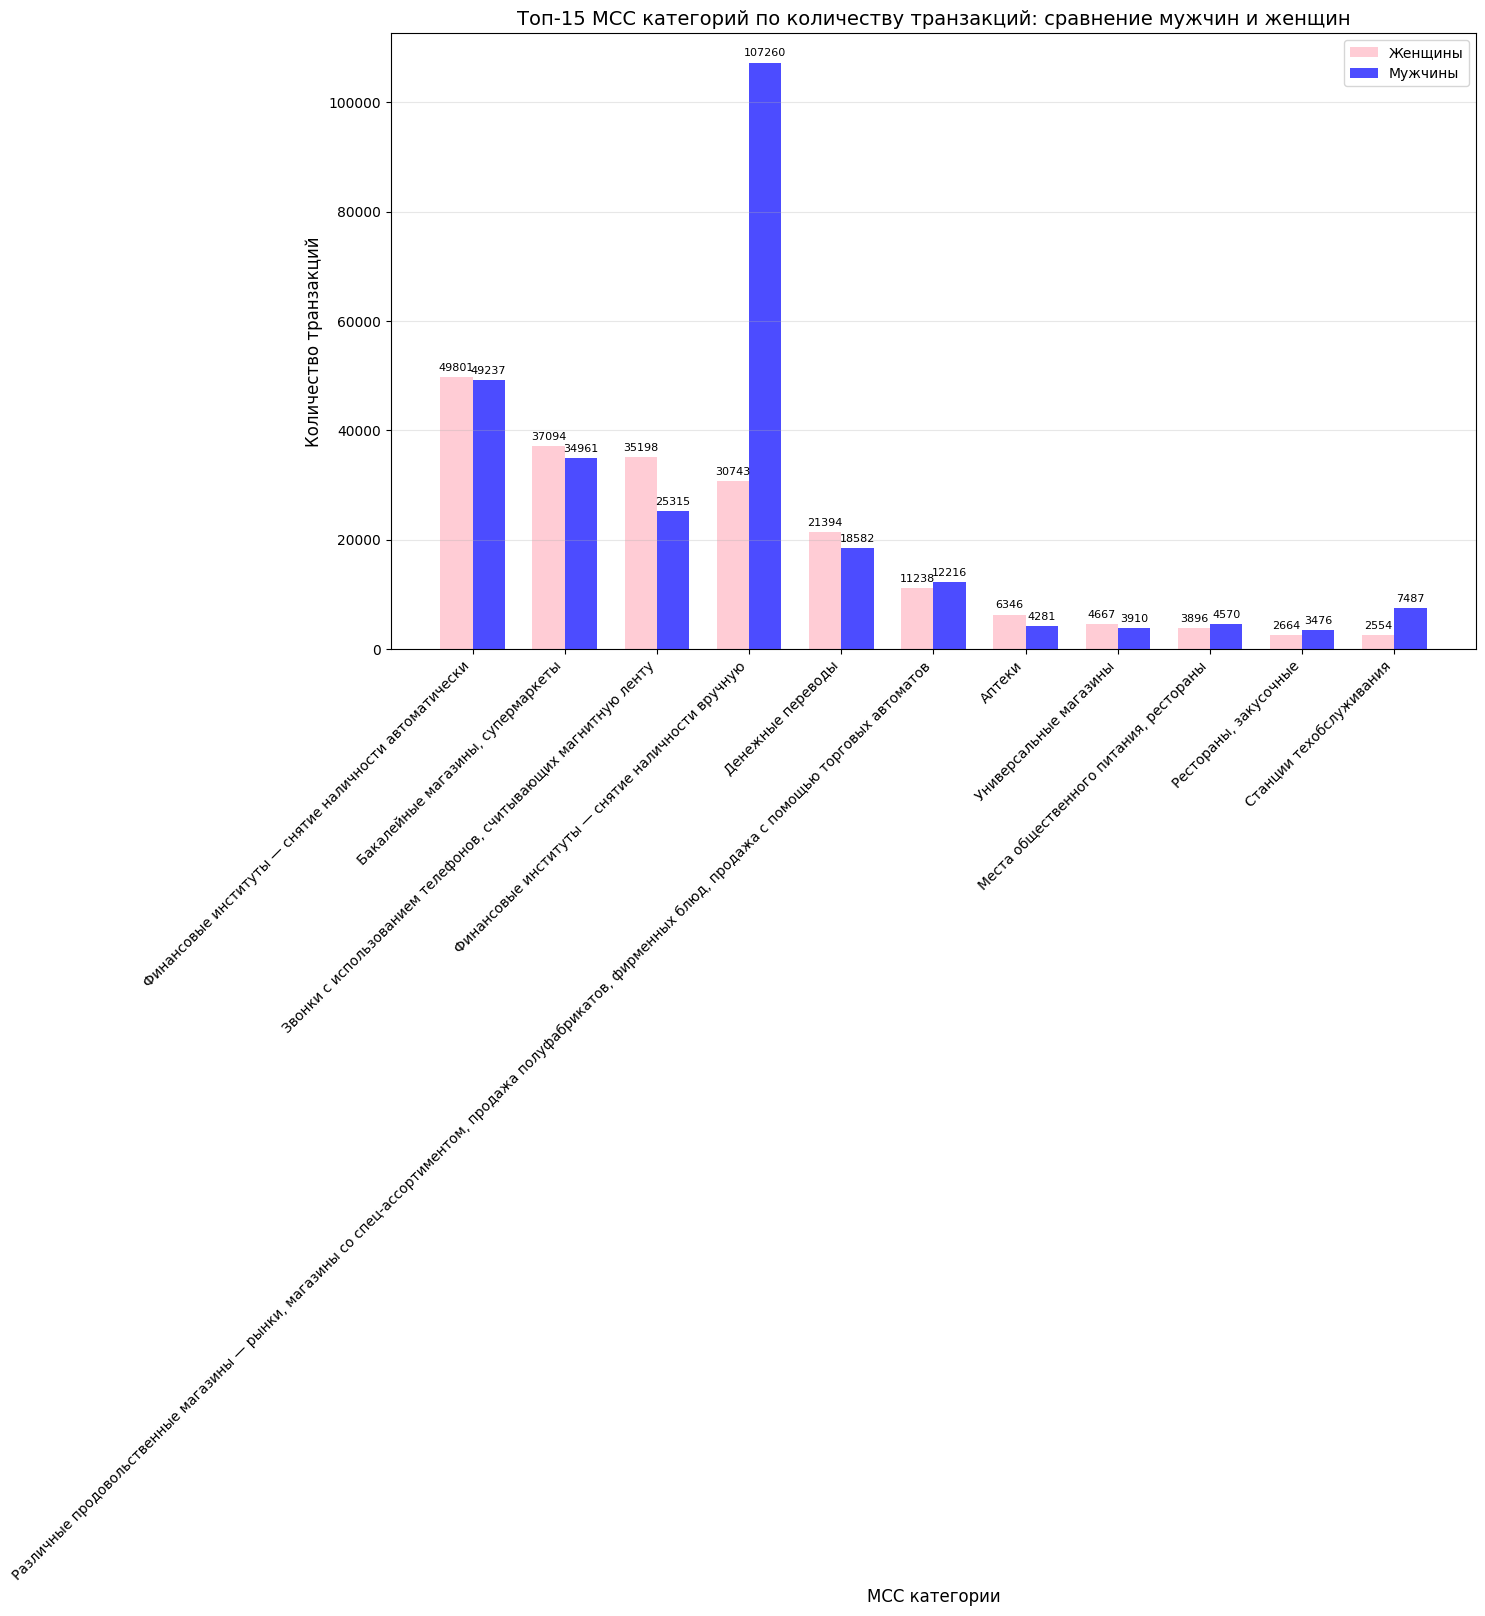

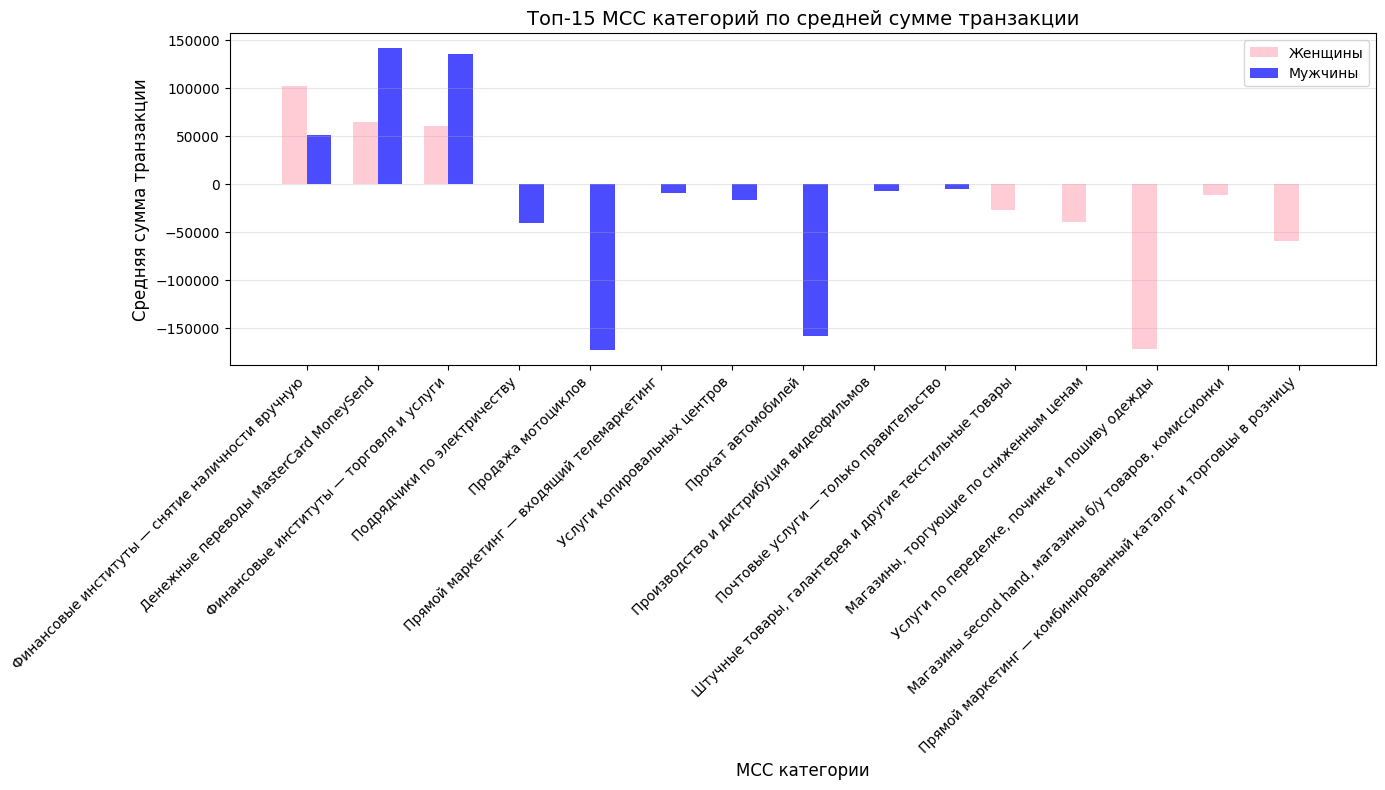

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Чтение данных
tr_mcc_codes = pd.read_csv('tr_mcc_codes.csv', sep=';')
tr_types = pd.read_csv('tr_types.csv', sep=';')
transactions = pd.read_csv('transactions.csv', nrows=1000000)
customers_gender_train = pd.read_csv('gender_train.csv', sep=',')

# 2. Соединение данных
# Сначала inner join с tr_mcc_codes и tr_types
transactions = pd.merge(transactions, tr_mcc_codes, on='mcc_code', how='inner')
transactions = pd.merge(transactions, tr_types, on='tr_type', how='inner')

# Затем left join с customers_gender_train
transactions = pd.merge(transactions, customers_gender_train, on='customer_id', how='left')

# Проверяем количество строк
print(f"Количество строк после соединения: {len(transactions)}")
print(f"Должно быть 999584 строк: {len(transactions) == 999584}")

# 3. Выделение относительного дня
transactions['tr_day'] = transactions['tr_datetime'].str.split().str[0]

# 4. Фильтрация: оставляем только те дни, где уникальных MCC кодов > 70
mcc_per_day = transactions.groupby('tr_day')['mcc_code'].nunique()
days_with_many_mcc = mcc_per_day[mcc_per_day > 70].index
transactions_filtered = transactions[transactions['tr_day'].isin(days_with_many_mcc)]

print(f"Количество строк после фильтрации: {len(transactions_filtered)}")

# 5. Группировка по MCC коду и полу
gender_mapping = {0: 'Female', 1: 'Male'}
transactions_filtered['gender_label'] = transactions_filtered['gender'].map(gender_mapping)

grouped = transactions_filtered.groupby(['mcc_code', 'gender_label']).agg({
    'amount': ['sum', 'mean', 'median', 'count']
}).reset_index()
grouped.columns = ['mcc_code', 'gender', 'sum_amount', 'mean_amount', 'median_amount', 'transaction_count']

# 6. Анализ для определения, кто относится к gender == 1
# Создаем сводную таблицу для сравнения расходов по полу
pivot_sum = grouped.pivot(index='mcc_code', columns='gender', values='sum_amount').fillna(0)
pivot_mean = grouped.pivot(index='mcc_code', columns='gender', values='mean_amount').fillna(0)
pivot_count = grouped.pivot(index='mcc_code', columns='gender', values='transaction_count').fillna(0)

# Добавляем MCC описания для анализа
pivot_sum = pivot_sum.merge(tr_mcc_codes[['mcc_code', 'mcc_description']],
                            left_index=True, right_on='mcc_code', how='left')
pivot_mean = pivot_mean.merge(tr_mcc_codes[['mcc_code', 'mcc_description']],
                              left_index=True, right_on='mcc_code', how='left')
pivot_count = pivot_count.merge(tr_mcc_codes[['mcc_code', 'mcc_description']],
                                left_index=True, right_on='mcc_code', how='left')

# Анализируем категории, типичные для мужчин и женщин
print("\n=== АНАЛИЗ КАТЕГОРИЙ ПО ПОЛУ ===\n")

# Категории с наибольшими расходами у женщин
print("ТОП-10 категорий с наибольшими расходами у ЖЕНЩИН:")
female_top = pivot_sum.nlargest(10, 'Female')[['Female', 'Male', 'mcc_description']]
print(female_top.to_string())
print()

# Категории с наибольшими расходами у мужчин
print("ТОП-10 категорий с наибольшими расходами у МУЖЧИН:")
male_top = pivot_sum.nlargest(10, 'Male')[['Female', 'Male', 'mcc_description']]
print(male_top.to_string())
print()

# Категории, где мужчины тратят значительно больше женщин
print("Категории, где МУЖЧИНЫ тратят значительно больше ЖЕНЩИН (отношение > 2):")
male_dominant = pivot_sum[pivot_sum['Male'] > pivot_sum['Female'] * 2].copy()
male_dominant['ratio'] = male_dominant['Male'] / male_dominant['Female'].replace(0, 1)
male_dominant = male_dominant.nlargest(10, 'ratio')[['Female', 'Male', 'ratio', 'mcc_description']]
print(male_dominant.to_string())
print()

# Категории, где женщины тратят значительно больше мужчин
print("Категории, где ЖЕНЩИНЫ тратят значительно больше МУЖЧИН (отношение > 2):")
female_dominant = pivot_sum[pivot_sum['Female'] > pivot_sum['Male'] * 2].copy()
female_dominant['ratio'] = female_dominant['Female'] / female_dominant['Male'].replace(0, 1)
female_dominant = female_dominant.nlargest(10, 'ratio')[['Female', 'Male', 'ratio', 'mcc_description']]
print(female_dominant.to_string())
print()

# 7. Определение, кто относится к gender == 1
print("=== ОПРЕДЕЛЕНИЕ ПОЛА ДЛЯ GENDER == 1 ===\n")

# Анализируем типично мужские и женские категории
typical_male_categories = [
    'Авиалинии, авиакомпании',
    'Станции техобслуживания',
    'Автозапчасти и аксессуары',
    'Автошины',
    'Подрядчики по электричеству',
    'Оборудование для водопровода и отопительной системы',
    'Скобяные товары в розницу',
    'Продажа мотоциклов',
    'Бизнес-сервис'
]

typical_female_categories = [
    'Магазины косметики',
    'Салоты красоты и парикмахерские',
    'Готовая женская одежда',
    'Аксессуары для женщин',
    'Обувные магазины',
    'Магазины по продаже часов, ювелирных изделий и изделий из серебра',
    'Магазины ткани, ниток рукоделия, шитья',
    'Флористика',
    'Аптеки'
]

print("Анализ типично мужских категорий:")
for cat in typical_male_categories:
    data = pivot_sum[pivot_sum['mcc_description'].str.contains(cat, na=False)]
    if not data.empty:
        male_spend = data['Male'].values[0]
        female_spend = data['Female'].values[0]
        print(f"{cat}: Мужчины = {male_spend:,.0f}, Женщины = {female_spend:,.0f}, М/Ж = {male_spend/female_spend:.2f}")

print("\nАнализ типично женских категорий:")
for cat in typical_female_categories:
    data = pivot_sum[pivot_sum['mcc_description'].str.contains(cat, na=False)]
    if not data.empty:
        female_spend = data['Female'].values[0]
        male_spend = data['Male'].values[0]
        print(f"{cat}: Женщины = {female_spend:,.0f}, Мужчины = {male_spend:,.0f}, Ж/М = {female_spend/male_spend:.2f}")

# На основе анализа делаем вывод
print("\n=== ВЫВОД ===")
print("Анализ показывает, что:")
print("1. В типично мужских категориях (автотовары, стройматериалы, техобслуживание) значительно больше тратят мужчины")
print("2. В типично женских категориях (косметика, женская одежда, аксессуары, салоны красоты) значительно больше тратят женщины")
print("3. Следовательно, gender == 1 соответствует МУЖЧИНАМ, а gender == 0 - ЖЕНЩИНАМ")

# 8. Столбчатая диаграмма
# Выбираем топ-10 категорий по объему транзакций для каждого пола
top_categories_female = pivot_count.nlargest(10, 'Female')[['Female', 'Male', 'mcc_description']].copy()
top_categories_male = pivot_count.nlargest(10, 'Male')[['Female', 'Male', 'mcc_description']].copy()

# Объединяем уникальные категории из обоих топов
all_top_categories = pd.concat([top_categories_female, top_categories_male])
all_top_categories = all_top_categories.drop_duplicates(subset=['mcc_description']).head(15)

# Подготовка данных для диаграммы
categories = all_top_categories['mcc_description'].values
female_counts = all_top_categories['Female'].values
male_counts = all_top_categories['Male'].values

# Создание столбчатой диаграммы
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, female_counts, width, label='Женщины', color='pink', alpha=0.8)
bars2 = ax.bar(x + width/2, male_counts, width, label='Мужчины', color='blue', alpha=0.7)

ax.set_xlabel('MCC категории', fontsize=12)
ax.set_ylabel('Количество транзакций', fontsize=12)
ax.set_title('Топ-15 MCC категорий по количеству транзакций: сравнение мужчин и женщин', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Добавление значений на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Дополнительная диаграмма: сравнение средних сумм транзакций
top_mean_female = pivot_mean.nlargest(10, 'Female')[['Female', 'Male', 'mcc_description']].copy()
top_mean_male = pivot_mean.nlargest(10, 'Male')[['Female', 'Male', 'mcc_description']].copy()

all_top_mean = pd.concat([top_mean_female, top_mean_male])
all_top_mean = all_top_mean.drop_duplicates(subset=['mcc_description']).head(15)

fig2, ax2 = plt.subplots(figsize=(14, 8))
categories2 = all_top_mean['mcc_description'].values
female_means = all_top_mean['Female'].values
male_means = all_top_mean['Male'].values

x2 = np.arange(len(categories2))
bars1_2 = ax2.bar(x2 - width/2, female_means, width, label='Женщины', color='pink', alpha=0.8)
bars2_2 = ax2.bar(x2 + width/2, male_means, width, label='Мужчины', color='blue', alpha=0.7)

ax2.set_xlabel('MCC категории', fontsize=12)
ax2.set_ylabel('Средняя сумма транзакции', fontsize=12)
ax2.set_title('Топ-15 MCC категорий по средней сумме транзакции', fontsize=14)
ax2.set_xticks(x2)
ax2.set_xticklabels(categories2, rotation=45, ha='right', fontsize=10)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()